# **Case Study 6**
## Particle Detection
  
  
---


# Team DEAN:
#### **D**avid Wei | **E**dward Roske | **A**dam Canton | **N**eil Benson

<a name="RemoveOutliers"></a>
# **Business Understanding** 
*   **Problem**: Superconductor client ABC's request is to predict the existence of a new particle given a very large, advanced data set.
*   **Objective**: Maximize accuracy on the new particle predictions using Neural Networks.
*   **Why This Is Important**: Detecting new particles can accelerate innovation in the highly competitive semiconductor market. Cutting edge innovations in the field can continue the advancement of the fundamental principle and technological benchmark, Moore's Law, that guides the course of modern computing and the semiconductor industry. While industry can continue to pack more and more transistors onto semiconductors, this is finite, while finding new particles with differing conductability can fundamentally change the way semiconductors are built and the way they advance technology and society.


  
# **Report Format**
* The research team felt that a thoughtful, easy-to-read PDF report was most helpful for quick consumption. That said, there is significant code, output, and diagrams throughout that contain the details that may be of interest to different readers. The team has interspersed commentary and feedback within the output below to succinctly tell the story while processing the data or modeling so reading the report flows mostly in a linear direction.   
  
---

Note: portions of code and/or text may have been used in previous case studies.  
  
<BR>

In [ ]:
import numpy as np
import pandas as pd
import time
import math
from scipy import stats

# Sklearn 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# from sklearnex import patch_sklearn
# patch_sklearn()

# PyTorch
import torch as torch
from torch import Tensor
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Softmax
from torch.nn import Module
from torch.nn import Sigmoid
from torch.nn import BCELoss
from torch.optim import SGD
from torch.nn import CrossEntropyLoss
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_

from IPython import display
from tqdm import tqdm

In [ ]:
########## Installing PyTorch ##########
# Step 1: Check CUDA Version in cmd prmpt: cmd -> type 'nvidia-smi'
# Step 2: conda install pytorch torchvision torchaudio cudatoolkit=10.2 -c pytorch

# **Data Evaluation & Engineering**



## Summary of Data
Starting with a relatively clean data set, there were few modifications needed in order to bring the data up to the point where it could be easily modeled. 

The data had no missing values, nor duplicate rows or columns, though the data needed to be normalized in order to bring all predictors to the same scale. A single predictor was removed as it had high degrees of correlation with several other columns and was thus redundant. The target in the source data was well balanced, at almost a perfect 50/50 split.

The data contains a target variable, `# label` and 28 predictors which are labeled `f0` through `f26` and are without much context or description as to their value, meaning, or their relationship to one another. Finally, a `mass` predictor column is provided that is several orders of magnitude larger than all other variables and will need to be normalized as we proceed. 

Within the data target, class `1` is indicative of the detection of the new particle, while class `0` indicates that there was no detection of the new particle. 

In [ ]:
df = pd.read_csv("./Data/all_train.csv")

shape = df.shape
print(f"The data has {shape[0]:,} rows and {shape[1]} columns, including the target column '# label'. Becuase of the size of the data, it can't all be processed in memory at once. We will proceed with chunking in order to 'stream' the data from the file. This will allow us to train the Neural Network from one chunk to the next as we back propogate and update the weights.")

The data has 7,000,000 rows and 29 columns, including the target column '# label'. Becuase of the size of the data, it can't all be processed in memory at once. We will proceed with chunking in order to 'stream' the data from the file. This will allow us to train the Neural Network from one chunk to the next as we back propogate and update the weights.


In [ ]:
# handling some of the data manipulation up front to save to CSV for later processing
# notes and details of adjustments listed in sections below

# Removing outliers greater than 3 standard deviations away
df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

# saving cleaned up data back to CSV for later processing
df.drop(["f6"], axis=1).to_csv("./Data/all_train_clean.csv", index=False, encoding="utf-8")

new_shape = df.drop(["f6"], axis=1).shape

# sampling the data to 100k records, with random_state set for reproducibility
# sampling for EDA because this process is memory intensive
df = df.sample(n=100000, random_state=1)
df.reset_index(drop=True, inplace=True)

In [ ]:
df.head(5)

,# label,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f18,f19,f20,f21,f22,f23,f24,f25,f26,mass
0,1.0,-0.312045,0.766340,1.378885,-0.302112,0.594504,-1.054221,-0.122620,0.972939,0.686400,...,-0.114636,-0.185657,-1.471793,1.743123,1.188868,0.274954,-0.349619,-0.659388,-0.627205,499.999969
1,1.0,0.616157,-1.048020,-1.111451,0.495108,-1.240493,-0.005984,1.185306,0.546453,0.525325,...,-0.746017,-1.944018,-0.414281,-0.573682,1.179915,0.373137,-0.370153,2.085949,0.988382,1250.000000
2,0.0,-0.059104,-0.411309,-0.511346,-0.501253,0.503380,-1.054221,-1.822713,0.507773,0.804722,...,-1.642341,-0.318450,-0.997849,-0.573682,-1.101027,-1.431229,-0.264227,-0.864956,-1.898312,1500.000000
3,0.0,-1.765433,-0.515588,0.299315,-0.265132,1.571326,-0.005984,-0.429770,1.636836,0.099510,...,0.860005,-0.486382,-1.393335,-0.573682,-0.821240,-0.752149,-0.342874,-0.150846,-0.390525,1500.000000
4,0.0,0.674855,-0.436727,0.528295,-0.347821,-0.224844,-1.054221,-0.825310,0.642521,-1.539702,...,-1.400071,0.594986,-0.429181,-0.573682,0.331389,0.721259,0.318719,0.537545,-0.434885,750.000000


Of the 28 predictors, all were in float format. Changes to data types were not needed in order to proceed. Predictor `mass` however is several orders of magnitude larger than all other predictors, and will need to be normalized in order to bring all the predictors to the same scale. This will be performed during chunking.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 29 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   # label  100000 non-null  float64
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   f3       100000 non-null  float64
 5   f4       100000 non-null  float64
 6   f5       100000 non-null  float64
 7   f6       100000 non-null  float64
 8   f7       100000 non-null  float64
 9   f8       100000 non-null  float64
 10  f9       100000 non-null  float64
 11  f10      100000 non-null  float64
 12  f11      100000 non-null  float64
 13  f12      100000 non-null  float64
 14  f13      100000 non-null  float64
 15  f14      100000 non-null  float64
 16  f15      100000 non-null  float64
 17  f16      100000 non-null  float64
 18  f17      100000 non-null  float64
 19  f18      100000 non-null  float64
 20  f19      100000 non-null  f

Listing out the columns, noting the target `# label` and the `mass` predictor.

In [ ]:
df.columns

Index(['# label', 'f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9',
       'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19',
       'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'mass'],
      dtype='object')

## **Data Issues** 
Checking for duplicate data, outliers, variables not needed, and missing values. 

#### **Feature Engineering**:  
 Since the data consisted almost entirely of predictors without context or descriptive column names or metadata describing the data, creating new features would have been problematic. As such, the team worked with the current metrics and did not engineer new features. Additionally, testing with existing features resulted in satisfactory accuracy to the point that features need not be added. 

#### **Missing Values**:  
 No missing values to impute.

In [ ]:
missing = df.columns[df.isnull().any()].tolist()
print(f"There are {len(missing)} values missing in this dataset.")

There are 0 values missing in this dataset.


#### **Duplicate Data**:  
Checking for duplicate data, no duplicated rows or columns were found. Proceeded without deleting any rows or columns.

Check for duplicate rows:

In [ ]:
def remove_dups(df, y):
    def check_fullrow_dups(df):
        dups = df.loc[:, df.columns != y].duplicated().sum()
        perc_duplicate = dups/len(df)*100
        return perc_duplicate
        #f"{dups/len(df)*100:1.2f}% of all records are considered duplicates"
        # source:
        # adapted from: https://stackoverflow.com/questions/35584085/how-to-count-duplicate-rows-in-pandas-dataframe

    if check_fullrow_dups(df) != 0:
        duplicated_rows = df[df.duplicated()]
        print(f"{check_fullrow_dups(df)}% of all records are considered duplicates")
        print('\n')
        df_dupes_removed = df.drop_duplicates(keep=False, inplace=False)
        print('# of duplicates removed: '+str(len(duplicated_rows)))
        print('\n')
        print('Response Class Duplicates: \n'+str(pd.value_counts(duplicated_rows.Action)))
        print('\n')
    else: 
        print('There are 0 duplicated rows in this dataset.')

    # return df_dupes_removed

if remove_dups(df, 'mass') == None:
    pass
else:
    df = remove_dups(df, 'mass')
    print('# of records remaining: '+str(len(df)))

There are 0 duplicated rows in this dataset.


Check for duplicate columns:

In [ ]:
dup_cols = sum(df.columns.duplicated())
print(f"There are {dup_cols} duplicated columns in this dataset.")

There are 0 duplicated columns in this dataset.


## **Exploratory Data Analysis**

#### **Identifying Outliers**:  

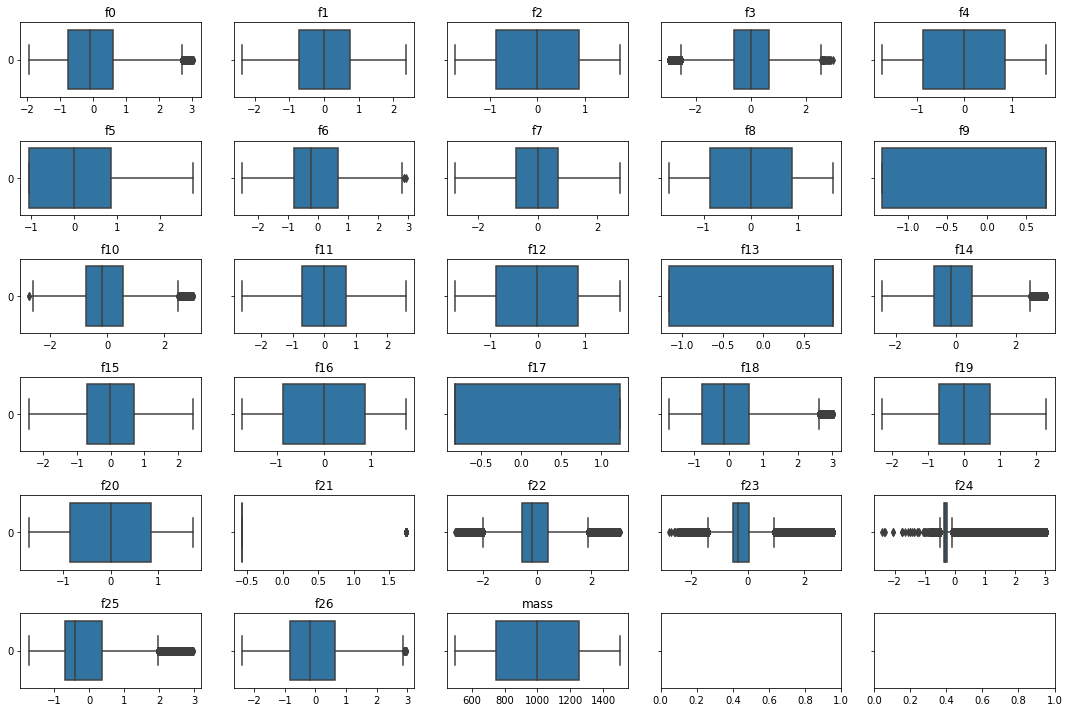

In [ ]:
def draw_boxplots(df, n_cols=5):
    n_rows = math.ceil(len(df.columns) / n_cols)
    fig, ax = plt.subplots(ncols=n_cols, nrows=n_rows, sharey=True,figsize=(15,10))
    for i, var_name in enumerate(df.columns):
        sns.boxplot(data=df[var_name], ax=ax[i//n_cols][i - (n_cols * (i//n_cols))], orient="h").set_title(var_name)
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()


draw_boxplots(df=df.loc[:, df.columns != "# label"])

#### **Handling Outliers**: 
The team made the decision to remove outliers further than 3 standard deviations away from the norm. Because we have a lot of data, our sampling won’t be hurt by dropping or ignoring questionable outliers. We'll examine skew further to determine if transformations are needed for the data.

~~~python
# Removing outliers greater than 3 standard deviations away
df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]
~~~

#### **Checking the Normalcy of Predictors**:  
Checking the distribution of the predictor variables, we observed moderate skew in a handful of variables, but not enough to transform the data.

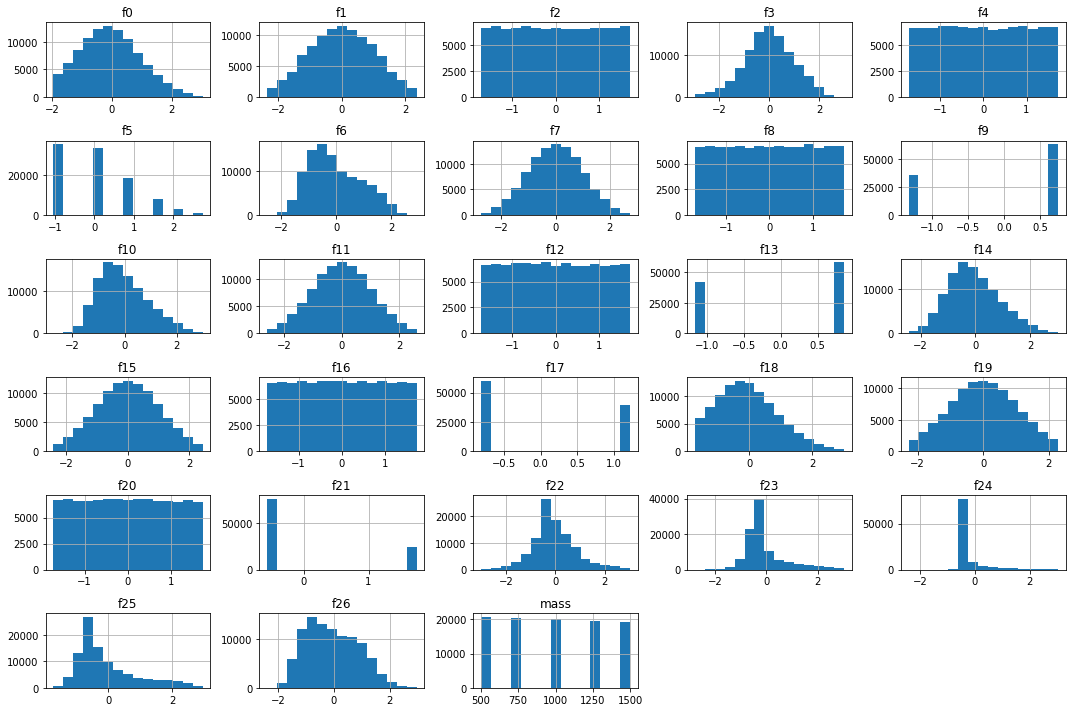

In [ ]:
# checking to see if the attributes are normally distributed, if not transform
def draw_histograms(df, n_cols=5):
    n_rows = math.ceil(len(df.columns) / n_cols)
    fig = plt.figure(figsize=(15, 10))
    for i, var_name in enumerate(df.columns):
        ax = fig.add_subplot(n_rows, n_cols, i + 1)
        df[var_name].hist(bins=15, ax=ax)
        ax.set_title(var_name)
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()


draw_histograms(df=df.loc[:, df.columns != "# label"])

Checking the distribution of all the predictors, we saw that there was some moderate right skew in `f0`, `f5`, `f10`, `f14`, `f18`, `f22`, `f23`, `f24`, `f25`, and `f26`. 

Similarly, we saw some slight left skew in `f3`.

Because the skew is moderate, simple transformations of the predictors would result in skew in the opposite direction. Proceeded without transforming any of the predictor variables, but noting slight skew for the columns noted above.

#### **Variables Not Needed**:  
   Checking for predictor variables that have high degrees of multicolinearity. It was determined that one of the predictors, `f6` showed high degrees of multicolinearity with two others, `f10` and `f26`. As such, `f6` was removed from the data set to reduce redundancy within the data.

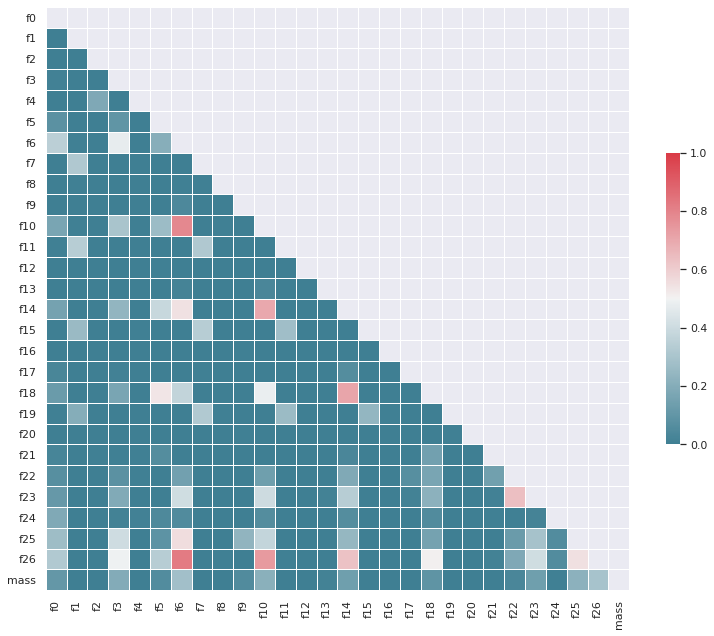

In [ ]:
# plot the correlation matrix using seaborn
sns.set(style="darkgrid")

# Compute the correlation matrix
corr = df.loc[:, df.columns != "# label"].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    vmin=0,
    vmax=1,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
)

f.tight_layout()

 Most of the columns show little to no correlation, however
 we see high degrees of correlation between `f6` & `f10`, `f6` & `f26`, and `f10` & `f26`.

In [ ]:
print(f"Correlation between f10 and f6: {df['f10'].corr(df['f6']):.2f}")
print(f"Correlation between f10 and f26: {df['f10'].corr(df['f26']):.2f}")
print(f"Correlation between f26 and f6: {df['f26'].corr(df['f6']):.2f}")

Correlation between f10 and f6: 0.79
Correlation between f10 and f26: 0.74
Correlation between f26 and f6: 0.82


Removing `f6` because it is redundant, and highly correlated with both `f26` and `f10`.

In [ ]:
df = df.drop(["f6"], axis=1)

#### **Checking the Balance of the Target**:
A balanced target meant there will be no further exploration or preparation regarding down sampling the data, or stratifying the splits when it comes time to split the test/train data.


There are 47652.0 classified as 1, and 52348.0 classified 0 making this an almost perfectly balanced target. This is representative of a sample of 100k records, however in our investigation into the entirity of the data set,  the full set of data showed an even closer balance of almost exactly 50/50 split.


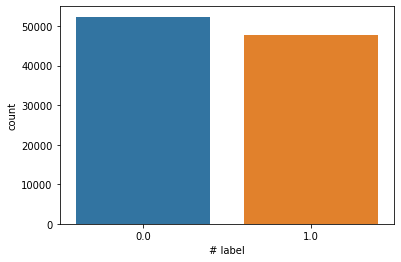

In [ ]:
sns.countplot(x=df["# label"])
on = df["# label"].sum()
off = len(df["# label"]) - on

print(
    f"\nThere are {on} classified as 1, and {off} classified 0 making this an almost perfectly balanced target.",
    "This is representative of a sample of 100k records, however in our investigation into the entirity of the data set,",
    " the full set of data showed an even closer balance of almost exactly 50/50 split."
)

In [ ]:
del df  # deleting object to save memory

## **Assumptions and Other Relevant Notes**:
* Mass is several orders of magnitude larger than all other predictors, so the data will need to be normalized.
* No missing data.
* No duplicated data.
* Predictor `f6` has a degree of correlation with `f10` and `f26` and has been dropped to reduce redundancy.
* Moderate skew in some of the predictors, but proceeded without transformation.
* Data with outliers and `f6` removed saved to a new CSV for streaming/chunking the data.
* Splitting, normalization, and separating label from predictors was taken care of in upcoming modeling.
* The data is so large that it affects performance if it's all put in-memory. With that, chunking/streaming the data will be necessary in order to run through neural network classification. 

## **Final Data Set**:


In [ ]:
print(f"The final data set contains {new_shape[0]:,} records, a target variable '# label', and {new_shape[1]-1} predictors.",
    "Normalization and data splitting (test/train) will be handled during chunking of the data. Outliers beyond 3 standard deviations have",
    "been removed as the data is large enough, sampling won’t be hurt by dropping or ignoring questionable outliers. This data set provided advantages",
    "in that there was relatively little prep work needed in order to bring the data to modeling spec."    
    )

The final data set contains 6,530,570 records, a target variable '# label', and 27 predictors. Normalization and data splitting (test/train) will be handled during chunking of the data. Outliers beyond 3 standard deviations have been removed as the data is large enough, sampling won’t be hurt by dropping or ignoring questionable outliers. This data set provided advantages in that there was relatively little prep work needed in order to bring the data to modeling spec.


# **Model Preparations**
*   **Proposed Methods**: From our EDA, the team found that there was exactly 7 million records in the dataset, but after removing outliers above 3 standard deviations, our final data set is ~6.5M records. Given the sheer volume of data, the team decided that modeling the entire data in one-go would result in not only poor compute performance but also make it very difficult to troubleshoot and analyze. Therefore, the team decided that the data would be fed into the model as smaller subsets of data (chunks) through Python Panda's IO library tools [read function](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html). To determine the chunk size, the team tested by iteratively measuring the memory sizes given varying chunk sizes by approximating 10mb as the standard sizing ([source](https://stackoverflow.com/questions/23369625/ideal-chunk-size-for-python-requests)). It was found that a chunk size of 50,000 (rows) was most appropriate occupying only 11 total mb per chunk with a total of ~131 total chunks. <br>
Due to the client's request on building out a binary classifier to maximize accuracy on the new particle predictions, the team recommended building out a complex dense neural network utilizing at minimum 3 hidden layers to better accomodate for the fairly large and unlabeled feature set ([source](https://www.linkedin.com/pulse/choosing-number-hidden-layers-neurons-neural-networks-sachdev/)) utilizing the PyTorch deep learning library. 4 comparison will then be built with varying levels of complexity by adding additional neurons in each dense hidden layer (see below). Model weights and biases found through the neural network backpropogation was saved at the end of each chunk and then fed into the next chunk iteration (for all chunks > 1), effectively training the total dataset as folds. In a production environment it is highly advisible to run any future modeling through a distributed system for a much more efficient and scalable load process.
    <a name="ModelComparisonList"></a>
    * **Proposed Models**: 
        * 1. 1 input layer with 28 inputs, 3 hidden layers each with **1** neuron(s) and 1 output layer
        * 2. 1 input layer with 28 inputs, 3 hidden layers each with **3** neuron(s) and 1 output layer
        * 3. 1 input layer with 28 inputs, 3 hidden layers each with **6** neuron(s) and 1 output layer
        * 4. 1 input layer with 28 inputs, 3 hidden layers each with **12** neuron(s) and 1 output layer
  
  
*   **Appropriateness**: Since the data provided is nondescript with each feature representing an arbritrary and unknown property of the particle, the team found that an iterative (chunking) approach to modeling will not only increase the overall compute time of our model building process but also allow for greater tuneability but evaluating the performance over a multitude of data subsets. 
  
<a name="EvalMetrics"></a>
*   **Evaluation Metrics and Why They're Useful**: As requested by the client, **Accuracy** will be used as the main evaluation metric for our overall modeling. A Loss Function and more specifically, the **Loss** per neural network process will the secondary metric of approximating the usefulness of our model at different steps (chunk number) of the model. The loss value will be derived at every Batch level and then calculated (shown in the bullet below) per Epoch to measure how the loss changes per increasing training cycle of the data.   
    * Epoch Loss = <code>SUM(Loss per Batch) / (Total Number of Batches per Epoch)</code>

# **Model Building & Evaluation**
*   **Sampling Methodology**: The team proposed that since the process of chunking the entire dataset essentially divided the total amount of data into separate groups (131 chunks), that each chunk would require sampling, defining the training and testing split and normalization. The following descriptions of the sampling process will be for each chunk and assumes repetition for all 140 chunks. 
    * **Train/Test Split**: The target response variable of '# label' is removed and stored as variable 'y' with a LabelEncoder applied to convert all response variables into binary numerical values. All remaining features excluding those removed during EDA were stored as 'X' and then applied with a 70/30 (Train/Test) split. The resulting split dataset was then normalized via a StandardScalar to scale any remaining variance without changing the overall weights of the input data.
    * **PyTorch Shuffling and Batching**: After the training and test split, both sets of data was converted to a [tensor](https://pytorch.org/tutorials/beginner/examples_tensor/two_layer_net_tensor.html) in a **TensorDataset** which is conceptually identical to that of a numpy matrix array which makes the data useful for futher computing. A TensorDataset is then loaded into a PyTorch iterable called [DataLoader](https://pytorch.org/docs/stable/data.html) which allows us to configure how we want the data to be configured prior to modeling. The following DataLoader configurations are specified below:
        * **Batch Size**: Both the Training and Testing datasets are configured to load in 2500 batches of data per iteration. This means that with a chunk size of 50000 and a training size of 35000 (per chunk), 1 epoch would equate to 14 batches.
        * **Shuffle**: The shuffle parameter is set to True for the training set which sequentially permutes the indices of all the samples for the training and testing dataset. The shuffling of the data is completed at each epoch and will allow the model to avoid over and underfitting. Since the Testing set is not iterated at a batch nor epoch level (though it is still chunked), no shuffling of the data is configured (```shuffle=False```).

*   **Constructing Model Architecture**: 
    * **Neural Network Model Configuration**:
        * Training Batch Size = 2,500
        * Testing Batch Size = 2,500
        * Number of Epochs = 10
        * Chunksize = 50,000
        * Total # of Chunks (based on chunksize) = 131
    * **Neural Network Design**:
        * **Input Layer**: The input layer is set to have the nodes equal the total number of features in our data (27).
        * **Hidden Layer(s)**:  The input nodes are then fed and transformed into 3 hidden **Linear** layers utilizing the Linear Transformation module with the additive bias set to True (bias=True) and the input and output parameters equaling our input nodes and varying output neurons, respectively (see [Model Comparison](#ModelComparisonList) for more details). It is to note here that for the first chunk (```Chunk_num = 0```), this creates the model weight matrix with a random bias vector and all successive chunks will inherit the optimized weights and biases. 
            * **Activation Function**: During forward propogation, to initialize the weights of our first hidden layer, a [Kaiming Uniform](https://pouannes.github.io/blog/initialization/) method (also known as the He Initilization) is used with the **ReLU Activation Function** (Rectified Linear Unit). The ReLU activation function is used since it overcomes the problem of vanishing gradients in *binary classification* problems ([source](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/)). For the last hidden layer (layer 3) a **Xavier** scheme is used to initialize the weights. This approach was used as [research](https://stats.stackexchange.com/questions/319323/whats-the-difference-between-variance-scaling-initializer-and-xavier-initialize/319849) indicated using Sigmoid as the output layer activation function resulted in better results (more discussion on this layer) and that the Xavier initilization method worked best with the Sigmoid Activation function whereas the He (Kaiming) initilization method worked best with the ReLU activation function.  
            * **Backpropagation**: Back-propogation is optimized using Stochastic Gradient Descent (SGD) to estimate the weights and biases. A small Learning Rate set to 0.01 (```lr=0.01```) with the Momentum set to 0.9 (```momentum=0.9```). The learning rate of 0.01 is used as it represents a good starting point and "typically works for standard standard multi-layer neural networks" ([source](https://machinelearningmastery.com/learning-rate-for-deep-learning-neural-networks/#:~:text=A%20traditional%20default%20value%20for,starting%20point%20on%20your%20problem.)) and given that it's small, allows us to find a more optimal global minima resulting in more accurate outputs. A large Momentum of .9 is used in conjunction with a small learning rate to help smoothen and more importantly accelerate the velocity in which the learner finds global minima during optimization as shown by [Salk Institute's demonstration](https://cnl.salk.edu/~schraudo/teach/NNcourse/momrate.html) of a large vs small momentum where they reduced their model's training time by nearly 60%! 
            * **Loss Criterion**: Since we utilized SGD as our optimizer to find the weights, a standard (for most binary classification models) loss function using **Cross Entropy** was used to measure the model errors during the optimization process. 
        * **Output Layer**: Since our model classification is binary, a **Sigmoid Function** activation function is used to model our final model outputs as either 1 or 0. This approach is often the "standard" approach since feeding the loss function based Cross Entropy values into the Sigmoid does not result in an over or underflow of numbers ([source](https://towardsdatascience.com/sigmoid-activation-and-binary-crossentropy-a-less-than-perfect-match-b801e130e31)) and instead results in a "flattened" output layer using Sigmoid.  

*   **How to View the Results**: Since each model takes on average 10 minutes to run, the following section includes all outputs for each of our 4 models with increasing level of complexity (density of the hidden layers). To capture the results, all models were ran with performance metrics logged and visualizations saved to avoid clutter and redundance in the code. As a result, all code shows only the last model ran and not all models. 

*   **Fitting Model to Training Data**: As mentioned in the [Evaluation Metrics](#EvalMetrics) section, Loss was used as a metric of performance at each stage of the model process. Typically loss is measured at each Epoch and then tuned using the Training and Testing Loss Curves divergence per epoch iteration. However, since we applied a chunking approach to the data to increase compute performance, the team found it was not appropriate to display an excessive amount of Training/Testing Epoch Loss Curves since it would result in roughly 130 individual visualizations. As a result, the final loss values for all Epochs in each Chunk was captured and visualized (below).<br>
The team found that for all models, the first Chunk did most of the "work" in terms of optimization with every chunk after showing insignificant changes in the loss indicating that the initial chunk's data was consistent across all 131 iterations and inhereted all the nuances from the first chunk. This resulted with a sharp drop in overall loss at the first chunk (```chunk_num = 0```) decreasing from an average starting Loss Value of 0.7 to an average end loss of 0.4. For chunks after the intial chunk, the team found that for all 4 models that the changes are consistent with white noise and more or less shifts around the mean loss value found during the intial chunk. <br>
At an epoch level, the team observed that with increasing complexity in the number of nodes in each hidden layer, the Loss per Epoch converged much quicker with the end loss value. This trend can be see by comparing the the first and second "simple" models with only 1 and 3 nodes (per model) in each of the hidden layers slowly decreasing in value per chunk with each successive chunk starting with the last chunk's values. However, when observing Model 4, our most "complex" model with 12 nodes per hidden layer, we can see after the first chunk, the overall loss converges with the end loss value roughly after Chunk 4 (```chunk_num=4```). 
    * Model 1: 
        * <img src="https://raw.githubusercontent.com/bensonnd/msds/master/ds7333/case_study_6/Pics/Model_1-1-1-1-1_Loss.png" width=400 height=300> <img src="https://raw.githubusercontent.com/bensonnd/msds/master/ds7333/case_study_6/Pics/Model_1-1-1-1-1_Train-test-Loss.png" width=400 height=300>
    * Model 2: 
        * <img src="https://raw.githubusercontent.com/bensonnd/msds/master/ds7333/case_study_6/Pics/Model_1-3-3-3-1_Loss.png" width=400 height=300> <img src="https://raw.githubusercontent.com/bensonnd/msds/master/ds7333/case_study_6/Pics/Model_1-3-3-3-1_Train-test-Loss.png" width=400 height=300>
    * Model 3: 
        * <img src="https://raw.githubusercontent.com/bensonnd/msds/master/ds7333/case_study_6/Pics/Model_1-6-6-6-1_Loss.png" width=400 height=300> <img src="https://raw.githubusercontent.com/bensonnd/msds/master/ds7333/case_study_6/Pics/Model_1-6-6-6-1_Train-test-Loss.png" width=400 height=300>
    * Model 4: 
        * <img src="https://raw.githubusercontent.com/bensonnd/msds/master/ds7333/case_study_6/Pics/Model_1-12-12-12-1_Loss.png" width=400 height=300> <img src="https://raw.githubusercontent.com/bensonnd/msds/master/ds7333/case_study_6/Pics/Model_1-12-12-12-1_Train-test-Loss.png" width=400 height=300>
*   **Analysis of Model Performance**: Using Accuracy as our primary metric of overall model performance, we can see that as the model's complexity increases, so does its resulting accuracies. The team also interestingly observed that with added complexity, the overall accuracy potential also became more linear and less constant. While Model 1 and Model 2's accuracies flatlined after Chunk 0, it appears that Model 3 and 4's shows increasing growth in terms of "max accuracy" though further testing is required to validate this observation. By observing the changes in model accuracy per model, the team observed that after Model 2, the increases in performance was fractional (10^3 differences). 
    * **NOTE: X and Y labels for all charts below are in the wrong order (X=Chunk#,Y=Accuracy)**
    * Model 1 (1 input, 3 hidden layer [1-1-1], 1 output): **Acc = 0.825**
        * <img src="https://raw.githubusercontent.com/bensonnd/msds/master/ds7333/case_study_6/Pics/Model_1-1-1-1-1_Acc.png" width=400 height=300>
    * Model 2 (1 input, 3 hidden layer [3-3-3], 1 output): **Acc = 0.853**
        * <img src="https://raw.githubusercontent.com/bensonnd/msds/master/ds7333/case_study_6/Pics/Model_1-3-3-3-1_Acc.png" width=400 height=300>
    * Model 3 (1 input, 3 hidden layer [6-6-6], 1 output): **Acc = 0.853**
        * <img src="https://raw.githubusercontent.com/bensonnd/msds/master/ds7333/case_study_6/Pics/Model_1-6-6-6-1_Acc.png" width=400  height=300>
    * Model 4 (1 input, 3 hidden layer [12-12-12], 1 output):  **Acc = 0.856**
        * <img src="https://raw.githubusercontent.com/bensonnd/msds/master/ds7333/case_study_6/Pics/Model_1-12-12-12-1_Acc.png" width=400  height=300>

In [ ]:
# model definition
class MLP(Module):
    # define model elements
    def __init__(self, n_inputs):
        super(MLP, self).__init__()
        # input to first hidden layer
        self.hidden1 = Linear(n_inputs, 12)
        kaiming_uniform_(self.hidden1.weight, nonlinearity='relu')
        self.act1 = ReLU()
        # second hidden layer
        self.hidden2 = Linear(12, 12)
        kaiming_uniform_(self.hidden2.weight, nonlinearity='relu')
        self.act2 = ReLU()
        # third hidden layer
        self.hidden3 = Linear(12, 1)
        xavier_uniform_(self.hidden3.weight)
        # output layer
        self.act3 = Sigmoid()
 
    # forward propagate input
    def forward(self, X):
        # input to first hidden layer
        X = self.hidden1(X)
        X = self.act1(X)
         # second hidden layer
        X = self.hidden2(X)
        X = self.act2(X)
        # third hidden layer and output
        X = self.hidden3(X)
        X = self.act3(X)
        return X

def my_plot(epochs, loss):
    plt.title('Loss Curve per Chunk Iterations')
    plt.plot(epochs, loss)
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")  
    # plt.legend(['0', '1','2','3','4'])

def get_weights(model):
    for name, param in model.named_parameters():
        if param.requires_grad:
            param_name = name
            param_data = param.data
            print(name, param.data)


def train_model(train_dl, model, num_epochs):
    # define the optimization
    criterion = BCELoss()
    optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
    loss_vals = []
   
    for epoch in range(num_epochs):
        epoch_loss = []

        # enumerate mini batches
        for i, (inputs, targets) in enumerate(train_dl):
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            yhat = model(inputs)
            # calculate loss
            loss = criterion(yhat, targets)
            # credit assignment
            loss.backward()
            # update model weights
            optimizer.step()

            # append epoch_loss
            epoch_loss.append(loss.item()) #note item() holds the value of the tensor
        # append loss value for all epochs
        loss_vals.append(sum(epoch_loss)/len(epoch_loss))

    # plotting
    my_plot(np.linspace(1, num_epochs, num_epochs).astype(int), loss_vals)
    return loss_vals

# evaluate the model
def evaluate_model(test_dl, model):
    criterion = BCELoss()
    predictions, actuals = list(), list()
    loss_vals = []
    for i, (inputs, targets) in enumerate(test_dl):
        row_loss = []
        # evaluate the model on the test set
        yhat = model(inputs)
        # calculate loss
        loss = criterion(yhat, targets)
        row_loss.append(loss.item())

        # retrieve numpy array
        yhat = yhat.detach().numpy()
        # finding actual values
        actual = targets.numpy()
        actual = actual.reshape((len(actual), 1))
        # round to class values
        yhat = yhat.round()
        # store predicted and actual values
        predictions.append(yhat)
        actuals.append(actual)

    predictions, actuals = np.vstack(predictions), np.vstack(actuals)
    # calculate accuracy
    acc = accuracy_score(actuals, predictions)

    loss_vals.append(row_loss)
    return acc, loss_vals

# make a class prediction for one row of data
def predict(row, model):
    # convert row to data
    row = Tensor([row])
    # make prediction
    yhat = model(row)
    # retrieve numpy array
    yhat = yhat.detach().numpy()
    return yhat

131it [06:43,  3.08s/it]


Model Run Time: 6.732718030611674 minutes


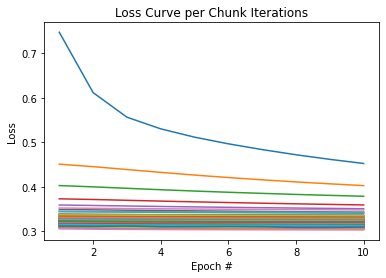

In [ ]:
############### Model Configurables ###############
sample_filename = './Data/all_train_sample.csv'
filename = './Data/all_train_clean.csv'

sample_chunksize =  10000
chunksize =  50000
# batch size
train_batch_size = 2500
test_batch_size = 2500
# epochs
num_epochs = 10

chunk_accuracies = []
train_loss = []
test_loss = []

############### Model Run ###############
start_time = time.time()
with pd.read_csv(filename, chunksize=chunksize) as reader:
    for chunk_num, chunk in tqdm(enumerate(reader)):
        #print(f'Processing Chunk #: {chunk_num}')
        # print(f'chunk size: {len(chunk)}')
        # print(f'chunk memory size (mb): {sys.getsizeof(chunk)/float(1<<20):.2f}')

        ############### Data Prep & Splitting ###############
        df = pd.DataFrame(chunk)
        X = df.loc[:, df.columns != "# label"]
        X_col_names = list(X.columns)
        y = df["# label"]

        X = X.astype('float32')

        y = LabelEncoder().fit_transform(y)
        y = y.astype('float32')
        y = y.reshape((len(y), 1))


        X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42,test_size=.3)

        ############### Scaling the Data ###############
        # Because we see that mass is orders of magnitude higher than all other fields, we will normalize/scale the data
        #  Keeping our test and training sets separate and scaling them independently to avoid data snooping.
        scaler = StandardScaler()

        ############### Convert np arrays back to dataframes ###############
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.fit_transform(X_test)

        ############### PyTorch Init ###############
        train_dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
        test_dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))

        train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                        batch_size=train_batch_size, 
                                        shuffle=True)
        test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                        batch_size=test_batch_size, 
                                        shuffle=False)
        #print(f'training size: {len(train_dataset)}')


        ############### Initialize Model ###############
        # ADD YOUR DIR HERE 
        model_dir = 'G:/My Drive/Masters/Summer 2021 (NLP, QTW, Cap A)/DS 7333 - Quantifying the World/Case Studies/Case Study 6/Models/particle-model'
        input_nodes = len(X_col_names)

        if chunk_num == 0:
            model = MLP(input_nodes)
            #print(f'new model')
        else: 
            model = torch.load(filepath)
            #print(f'existing model: {model_dir}')

        ############### Training Model ###############
        train = train_model(train_loader, model, num_epochs)
        train_loss.append(train[0])

        # print model weights
        #get_weights(model)

        # my_plot([0, 2, 3, 4, 5], [100, 90, 60, 30, 10])

        ############### SAving Model Weights ###############
        #Save model weights per chunk to pass to next iterative chunk after chunk==0
        direc = 'G:/My Drive/Masters/Summer 2021 (NLP, QTW, Cap A)/DS 7333 - Quantifying the World/Case Studies/Case Study 6/Models/'
        filename = 'particle-model'
        filepath = direc+filename
        torch.save(model, filepath)
     

        ############### Predicting Accuracies ###############
        # evaluate the model
        acc,loss = evaluate_model(test_loader, model)
        # appending loss values per chunk
        test_loss.append(loss)

        # store accuracies per chunk
        chunk_accuracies.append(acc)

        # print('Accuracy: %.3f' % acc)
        # print('Loss: %.3f' % train[0])
        # print(f'{"-"*10} end of chunk {"-"*10}\n')

print("Model Run Time: %s minutes" % ((time.time() - start_time)/60))

### Visualizing Train and Test Loss Curves

Text(0.5, 0, 'Chunk #')

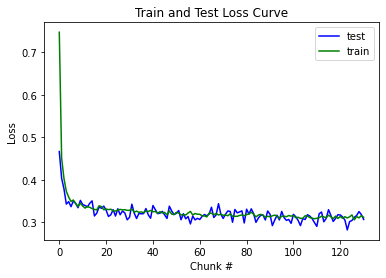

In [ ]:
test_loss = [i[0][0] for i in test_loss]

fig, ax = plt.subplots()
sns.lineplot(data=test_loss, ax=ax, color='blue', label='test')
sns.lineplot(data=train_loss, ax=ax, color='green', label='train')
ax.set_title('Train and Test Loss Curve')
ax.set_ylabel('Loss')
ax.set_xlabel('Chunk #')

### Visualizing Model Accuracies per Chunk Iteration

Average Model Accuracy: 0.848
Average Model Training Loss: 0.326
Average Model Testing Loss: 0.321


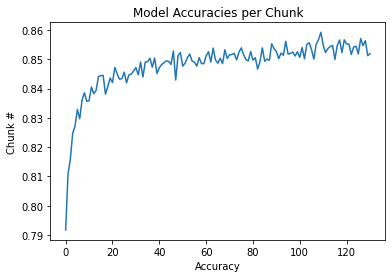

In [ ]:
ax = sns.lineplot(data=chunk_accuracies)
ax.set(xlabel='Accuracy', ylabel='Chunk #',title='Model Accuracies per Chunk')

avg_accuracy = np.mean(chunk_accuracies)
print(f'Average Model Accuracy: {avg_accuracy:.3f}')

avg_train_loss = np.mean(train_loss)
print(f'Average Model Training Loss: {avg_train_loss:.3f}')

avg_test_loss = np.mean(test_loss)
print(f'Average Model Testing Loss: {avg_test_loss:.3f}')

# **Case Conclusions**
*   **Conclusion**: The team found that by increasing the complexity of the neural network models, the best model was that consisting of the most complex design: 3 hidden layers each with 12 neurons (with an Accuracy of 0.856 and average Testing Log Loss of 0.321). At the current model design state, roughly 8 out of every 10 new particles are predicted accurately while 2 of the 10 new particles are not.
*   **How to View the Results**: Though the results are at best, moderately good, in the world of semiconductors, having an accuracy of roughly 85% in predicting the existence of a new particle can help our client significantly cut costs on manual experimentation expenses. The reality is often that a true accuracy of 100% is an impossible task since that would assume the data provided features that account for all possibilities at a quantum level. Even the "best semiconductors" today operate at around only 10-20% efficiency ([source](https://www.sciencedaily.com/releases/2021/02/210201101528.htm)).
*   **Possible Approaches Going Forward**: The team found that initial testing of the neural network model's complexity (with max density of 3 hidden layers each with 12 nodes) could further be improved on, however, only at the cost of expanding past the 5 hidden layer design and reaching within the boundaries of overfitting. The team found that ultimately at 3 hidden neural network design, there was diminishing returns (in terms of Accuracy) as added complexity only increased performance at a fractional rate. This being said, given the volume of the data, further studies with a 5 hidden layer design with varying complexity levels would result in potentially higher accuracies. 

# **Sources**:
* ## Model Building Sources:
    * Model Building Source: https://machinelearningmastery.com/pytorch-tutorial-develop-deep-learning-models/
    * For GPU-based compute: https://towardsdatascience.com/speed-up-your-algorithms-part-1-pytorch-56d8a4ae7051

* ## Plotting Loss Curve:
    * Source 1: https://discuss.pytorch.org/t/plotting-loss-curve/42632
    * Source 2: https://discuss.pytorch.org/t/how-to-plot-train-and-validation-accuracy-graph/105524/2